In [1]:
import pennylane as qml, numpy as np

In [2]:
def CliffordRX(angle: int, wires):
    """
    Returns the exp(-i theta/2 X) operator,
    for theta ∈ {0, pi/2, pi, 3pi/2},
    decomposed into basis operators accepted by the
    qml 'default.clifford' device.

    Args:
        integer_angle (int): theta / (pi/2)
    """
    if not isinstance(angle, (int, np.integer)):
        print(type(angle))
        raise TypeError(f"angle = {angle} should be integer")
    if angle % 4 == 0:
        qml.I(wires)
    elif angle % 4 == 1:
        qml.adjoint(qml.S(wires))
        qml.H(wires)
        qml.adjoint(qml.S(wires))
    elif angle % 4 == 2:
        qml.X(wires)
    elif angle % 4 == 3:
        qml.S(wires)
        qml.H(wires)
        qml.S(wires)

def CliffordRY(angle: int, wires):
    if not isinstance(angle, (int, np.integer)):
        print(type(angle))
        raise TypeError(f"angle = {angle} is of type {type(angle)}. It should be integer")
    if angle % 4 == 0:
        qml.I(wires)
    elif angle % 4 == 1:
        qml.H(wires)
        qml.X(wires)
    elif angle % 4 == 2:
        qml.Y(wires)
    elif angle % 4 ==3:
        qml.X(wires)
        qml.H(wires)

def random_thetas(size):
    possible_thetas = np.arange(4)
    return np.random.choice(possible_thetas, size)

def unit_vector(index, size):
    return np.array([
        1 if _ == index else 0
        for _ in range(size)
    ])

def simple_circuit(thetas):
    n_qubits = len(thetas)
    for i in range(n_qubits):
        CliffordRX(thetas[i], i)
    
    #measurements = [qml.expval(qml.Z(i)) for i in range(n_qubits)]
    #return np.sum(measurements)
    #return [qml.expval(qml.Z(i)) for i in range(n_qubits)]


def simple_gate(thetas, wires):
    # I should add here a "check thetas has len 4, wires has len 2"
    CliffordRX(thetas[0], wires[0])
    CliffordRX(thetas[1] ,wires[1])
    qml.CNOT(wires[0], wires[1])
    CliffordRY(thetas[2], wires[0])
    CliffordRY(thetas[3], wires[1])

def convoluting_layer(thetas, wires):
    # This function should take in 10 wires, and 4 * 21 = 84 thetas.
    ...

def PaoloCircuit():
    ...

In [3]:
def basis_encoding(x, n_qubits):
    xbin = np.binary_repr(x, n_qubits)
    for i in range(n_qubits):
        if xbin[i] == '1':
            qml.X(i)

In [4]:
n_qubits = 4
dev = qml.device('default.clifford', wires = ["a", "b", "c", "d, e"])

@qml.qnode(dev)
def f(thetas, x, dev):
    basis_encoding(x, len(dev.wires))
    simple_circuit(thetas)
    return [qml.expval(qml.Z(i)) for i in range(len(dev.wires))]

def grad_f(thetas, x):
    out = []
    for i in range(len(thetas)):
        f_plus = np.sum(f(thetas + unit_vector(i, len(thetas)), x))
        f_minus = np.sum(f(thetas - unit_vector(i, len(thetas)), x))
        out.append((f_plus - f_minus) / 2)
    return np.array(out)

def empirical_NTK(thetas, x, y):
    return np.dot(grad_f(thetas, x), grad_f(thetas, y))

def analytic_NTK_estimator(x, y, n_paramters, n_shots):
    return np.mean([
        empirical_NTK(random_thetas(n_paramters), x, y) for _ in range(n_shots)
    ])

In [5]:
dev.wires

Wires(['a', 'b', 'c', 'd, e'])

In [8]:
print(qml.draw(f)(random_thetas(4), 8, dev))

0: ──X──S†──H──S†─╭I─╭I──────────┤  <Z>
1: ───────────────├I─├I──────────┤  <Z>
2: ───────────────├I─├I──────────┤  <Z>
3: ───────────────╰I─╰I──S──H──S─┤  <Z>


In [154]:
analytic_NTK_estimator(0, 10, n_qubits, 300)

np.float64(0.013333333333333334)

In [123]:
len(dev.wires)

4

In [163]:
def all_thetas(n_parameters):
    from itertools import product
    return [
        np.array(theta_combination) for theta_combination in product(range(4), repeat= n_parameters)
    ]

def exact_analytic_NTK(x, y, n_parameters):
    return np.mean([
        empirical_NTK(thetas, x, y) for thetas in all_thetas(n_parameters)
    ])

In [168]:
exact_analytic_NTK(0, 2, n_qubits)

np.float64(1.0)

[1 0 2 0]


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

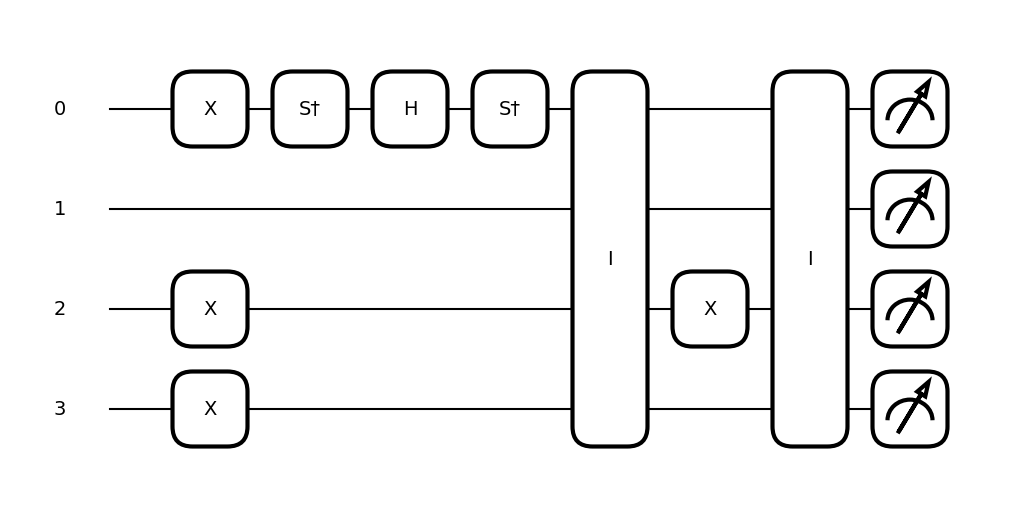

In [129]:
thetas = random_thetas(n_qubits)
print(thetas)
qml.draw_mpl(f)(thetas, 11)

In [89]:
out = np.sum(f([0,0, 0, 0], 0))
out

np.float64(4.0)